# Error Analysis

En esta notebook haremos análisis de error sobre nuestro modelo neuronal.

La idea es ver cómo se activan las neuronas de la LSTM, cuándo las compuertas se saturan, etc.


In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import csv
import numpy as np
import tensorflow as tf
import random
import torch

torch.manual_seed(2019)
np.random.seed(2019)
tf.random.set_random_seed(2019)
random.seed(2019)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

df_dev = pd.read_table("../../../data/es/dev_es.tsv", index_col="id", quoting=csv.QUOTE_NONE)
df_train = pd.read_table("../../../data/es/train_es.tsv", index_col="id", quoting=csv.QUOTE_NONE)
df_test = pd.read_table("../../../data/es/reference_es.tsv", header=None, 
                        names=["text", "HS", "TR", "AG"], quoting=csv.QUOTE_NONE)


text_train, y_train = df_train["text"], df_train["HS"]
text_dev, y_dev = df_dev["text"], df_dev["HS"]
text_test, y_test = df_test["text"], df_test["HS"]

print("Instancias de entrenamiento: {}".format(len(df_train)))
print("Instancias de desarrollo: {}".format(len(df_dev)))
print("Instancias de test: {}".format(len(df_test)))


Instancias de entrenamiento: 4500
Instancias de desarrollo: 500
Instancias de test: 1600


Cargamos datos dev con anotaciones propias

In [2]:
df_dev = pd.read_csv("dev_with_annotations.es.csv", index_col="id")

df_dev = df_dev[df_dev["text"].notnull()]


Cargamos modelos de fasttext y ELMo

In [3]:
%%capture
from elmoformanylangs import Embedder
import fastText
import os


fasttext_model = fastText.load_model(os.path.expanduser("../../../WordVectors/UBA_w3_300.bin"))
elmo_embedder = Embedder("../../../models/elmo/es/")

In [4]:
elmo_embedder.sents2elmo(["esto es una prueba"]);

## GRU + Global Max Pooling

In [16]:
from hate.nn import ElmoModel
from keras.optimizers import Adam

max_length = 40

model = ElmoModel(
    max_length, fasttext_model=fasttext_model,
    elmo_embedder=elmo_embedder, 
    rnn_units=200, dropout=0.75,
    pooling='avg',
    tokenize_args = {
        "preserve_case": False,
        "deaccent": False,
        "reduce_len": True,
        "strip_handles": True,
        "alpha_only": False,
        "stem": False
    }
)

#model.load_weights("../../../models/lstm_elmo.h5")
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 40, 1024)     0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 40, 300)      0                                            
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 40, 1324)     0           input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 40, 400)      1831200     concatenate_4[0][0]              
__________

In [17]:

optimizer_args = {
    "lr": 0.001,
    "decay": 0.01,
}

model.compile(loss='binary_crossentropy', 
              optimizer=Adam(**optimizer_args), 
              metrics=['accuracy'])

¿Cómo anda el tokenizador?

In [18]:
from nltk.tokenize import TweetTokenizer

nltk_tokenizer = TweetTokenizer(
    preserve_case=False, reduce_len=True, strip_handles=True)
tweet_prueba = "jajajaAJAjaj qué hdy culi4w @mauriciomacri #HashTag"

print("Nuestro tokenizador: ", model._tokenizer.tokenize(tweet_prueba))
print("El de NLTK: ", nltk_tokenizer.tokenize(tweet_prueba))

Nuestro tokenizador:  ['jajajaajajaj', 'qué', 'hdy', 'culi', '4w', '#hashtag']
El de NLTK:  ['jajajaajajaj', 'qué', 'hdy', 'culi', '4w', '#hashtag']


In [19]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpointer = ModelCheckpoint('/tmp/lstm_model.h5', save_best_only=True, monitor='val_acc', verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', patience=15)


model.fit(text_train, y_train, 
          callbacks=[checkpointer, early_stopper],
          validation_data=(text_dev, y_dev), epochs=100, batch_size=32)


Train on 4500 samples, validate on 500 samples
Epoch 1/100
4500/4500 [==============================] - 3s 699us/step - loss: 0.5804 - acc: 0.6962 - val_loss: 0.4515 - val_acc: 0.7920

Epoch 00001: val_acc improved from -inf to 0.79200, saving model to /tmp/lstm_model.h5
Epoch 2/100
4500/4500 [==============================] - 3s 561us/step - loss: 0.4173 - acc: 0.8053 - val_loss: 0.4358 - val_acc: 0.7960

Epoch 00002: val_acc improved from 0.79200 to 0.79600, saving model to /tmp/lstm_model.h5
Epoch 3/100
4500/4500 [==============================] - 2s 552us/step - loss: 0.3367 - acc: 0.8547 - val_loss: 0.4142 - val_acc: 0.8120

Epoch 00003: val_acc improved from 0.79600 to 0.81200, saving model to /tmp/lstm_model.h5
Epoch 4/100
4500/4500 [==============================] - 2s 535us/step - loss: 0.2797 - acc: 0.8816 - val_loss: 0.4121 - val_acc: 0.8140

Epoch 00004: val_acc improved from 0.81200 to 0.81400, saving model to /tmp/lstm_model.h5
Epoch 5/100
4500/4500 [=====================

In [21]:
from hate.utils import print_evaluation
print("biGRU + MaxPool1D - Elmo+Embeddings -- \n\n")
print("Evaluación sobre dev")

model.load_weights(checkpointer.filepath)

print_evaluation(model, text_dev, y_dev)
print("\nEvaluación sobre test")

print_evaluation(model, text_test, y_test)

biGRU + MaxPool1D - Elmo+Embeddings -- 


Evaluación sobre dev
500/500 [==============================] - 0s 264us/step
Loss           : 0.4452
Accuracy       : 0.8240
Precision(1)   : 0.8276
Precision(1)   : 0.8182
Precision(avg) : 0.8229

Recall(1)      : 0.7568
Recall(0)      : 0.8741
Recall(avg)    : 0.8154

F1(1)          : 0.7906
F1(0)          : 0.8452
F1(avg)        : 0.8179

Evaluación sobre test
1600/1600 [==============================] - 0s 275us/step
Loss           : 0.6404
Accuracy       : 0.7544
Precision(1)   : 0.6963
Precision(1)   : 0.7946
Precision(avg) : 0.7454

Recall(1)      : 0.7121
Recall(0)      : 0.7819
Recall(avg)    : 0.7470

F1(1)          : 0.7041
F1(0)          : 0.7882
F1(avg)        : 0.7462


## Activations

## Error Analysis

Vamos a ver los tweets con mayores errores

In [22]:
df_dev["proba"] = model.predict(text_dev)
df_dev["PROFANITY"] = 0


true_positives = df_dev[(df_dev["HS"] == 1) & (df_dev["proba"] >= 0.5)].copy()
true_negatives = df_dev[(df_dev["HS"] == 0) & (df_dev["proba"] < 0.5)].copy()

false_positives = df_dev[(df_dev["HS"] == 0) & (df_dev["proba"] > 0.5)].copy()
false_positives.sort_values("proba", ascending=False, inplace=True)


false_negatives = df_dev[(df_dev["HS"] == 1) & (df_dev["proba"] < 0.5)].copy()
false_negatives.sort_values("proba", ascending=True, inplace=True)

conf_matrix = pd.DataFrame([
    {"real":"hs=1", "pred_true": len(true_positives), "pred_false": len(false_negatives)},
    {"real":"hs=0", "pred_true": len(false_positives), "pred_false": len(true_negatives)}
])



conf_matrix.set_index("real", inplace=True)

print("Falsos negativos: {}".format(len(false_negatives)))
print("Falsos positivos: {}".format(len(false_positives)))

conf_matrix[["pred_true", "pred_false"]]

Falsos negativos: 53
Falsos positivos: 35


,pred_true,pred_false
real,,
hs=1,169,53
hs=0,35,243


In [23]:
from keras.models import Model
    

interm_model = Model(inputs=model.inputs, outputs=[model.recursive_layer])

In [24]:

text = true_positives.iloc[128]["text"]

text

'Pinche Astrid perra hasta en mis sueños eres tonta No te lo mereces 🙄'

In [25]:

tokenized_text = model._preprocess_tweet(text)
text_elmo, text_emb = model.preprocess_transform([text])

rnn_output = interm_model.predict([text_elmo, text_emb]).squeeze()

rnn_output.shape

(40, 400)

Traspose it so we have `(rnn_cells, tokens)` dimensions

In [26]:
rnn_output = rnn_output.T

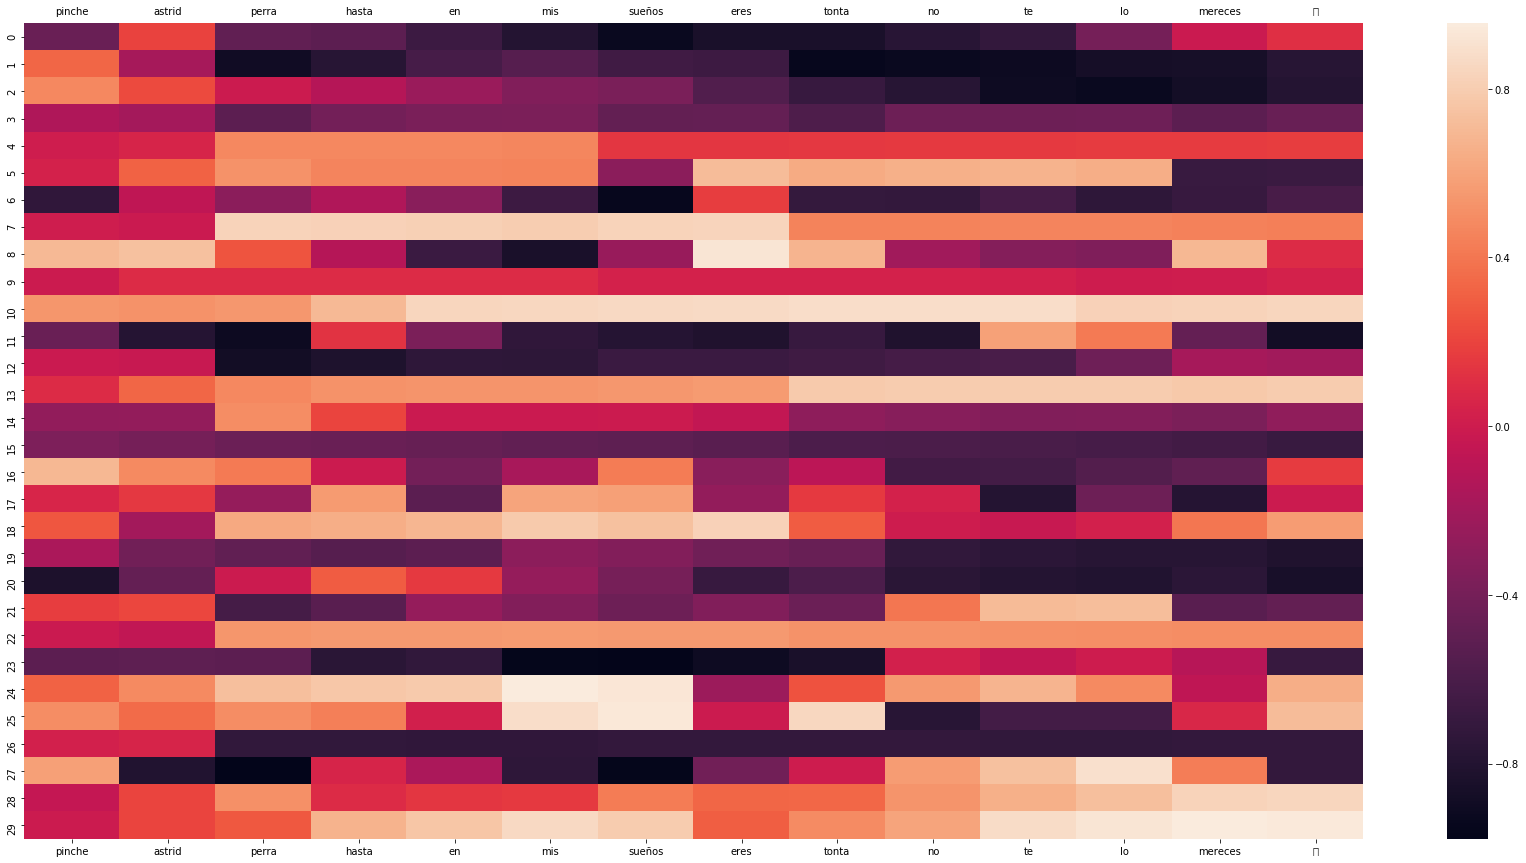

In [27]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

last_idx = next(j for j in range(len(tokenized_text), -1, -1) if tokenized_text[j-1] != '')

plt.rcParams["figure.figsize"] = (30,15)
plt.rcParams["xtick.labeltop"] = True 
ax = sns.heatmap(rnn_output[20:50, :last_idx], 
                 xticklabels=tokenized_text[:last_idx])

plt.xticks(rotation=0);

In [28]:
plt.rcParams["figure.figsize"] = (30,15)
plt.rcParams["xtick.labeltop"] = True 
    
def plot_recurrent_outputs(text):

    tokenized_text = model._preprocess_tweet(text)
    text_elmo, text_emb = model.preprocess_transform([text])

    rnn_output = interm_model.predict([text_elmo, text_emb]).squeeze()
    last_idx = next(j for j in range(len(tokenized_text), -1, -1) if tokenized_text[j-1] != '')
    
    rnn_output = rnn_output.T
    stride = 30
    num_cells = rnn_output.shape[0] // 2
    
    for j in range(num_cells // stride + 1):
        plt.figure()
        cell_idxs = range(stride*j, min(stride*(j+1), num_cells))
        sns.heatmap(
            rnn_output[cell_idxs, :last_idx], 
            xticklabels=tokenized_text[:last_idx],
            yticklabels=cell_idxs,
            cmap="coolwarm",
        )

        plt.xticks(rotation=0);

'@Haryachyzaychyk Callate zorra y mama duro! 😍'

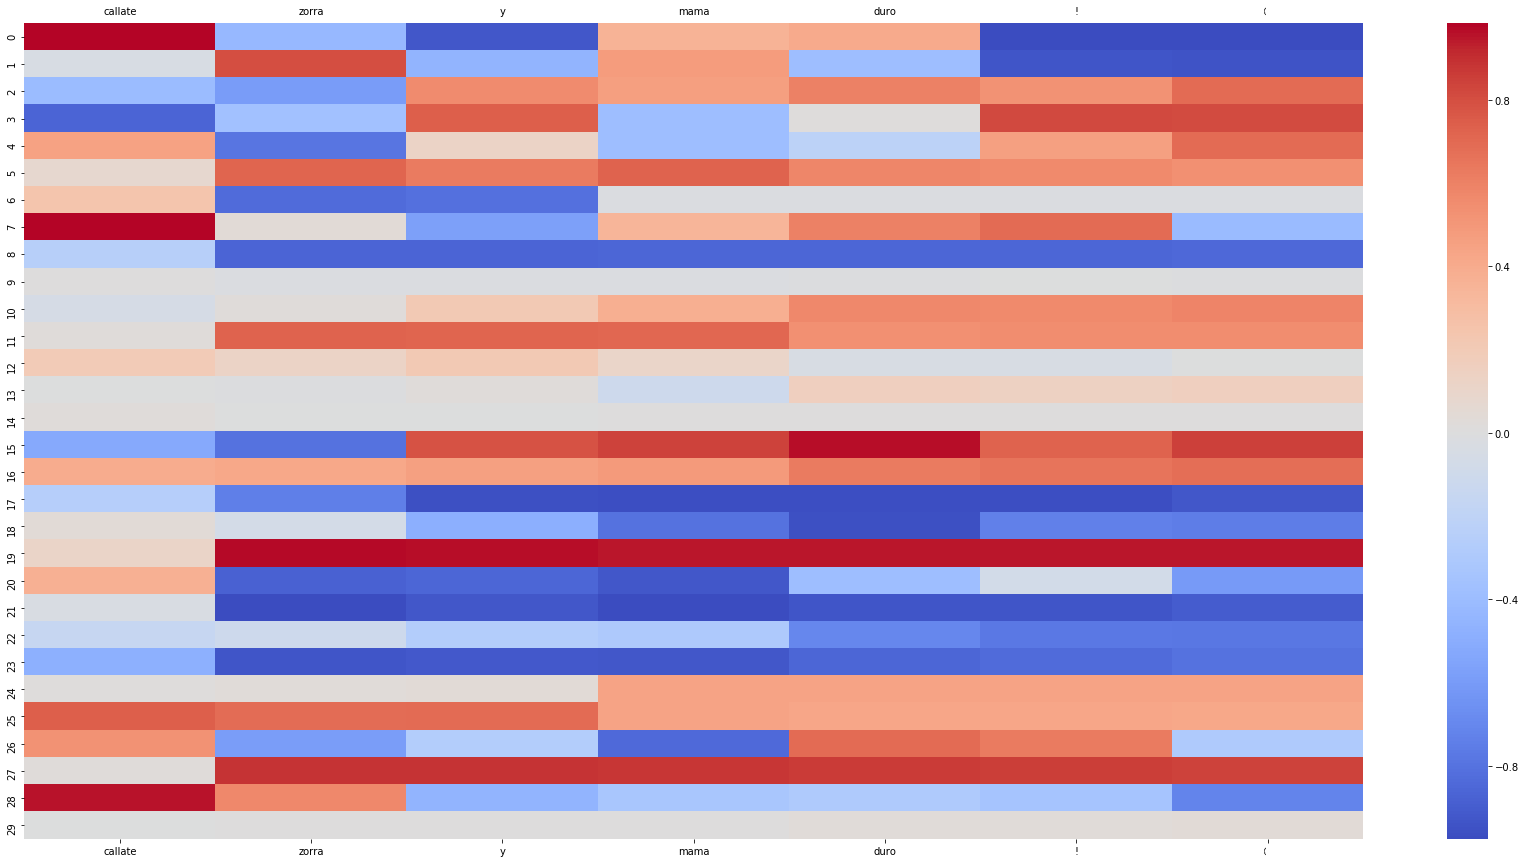

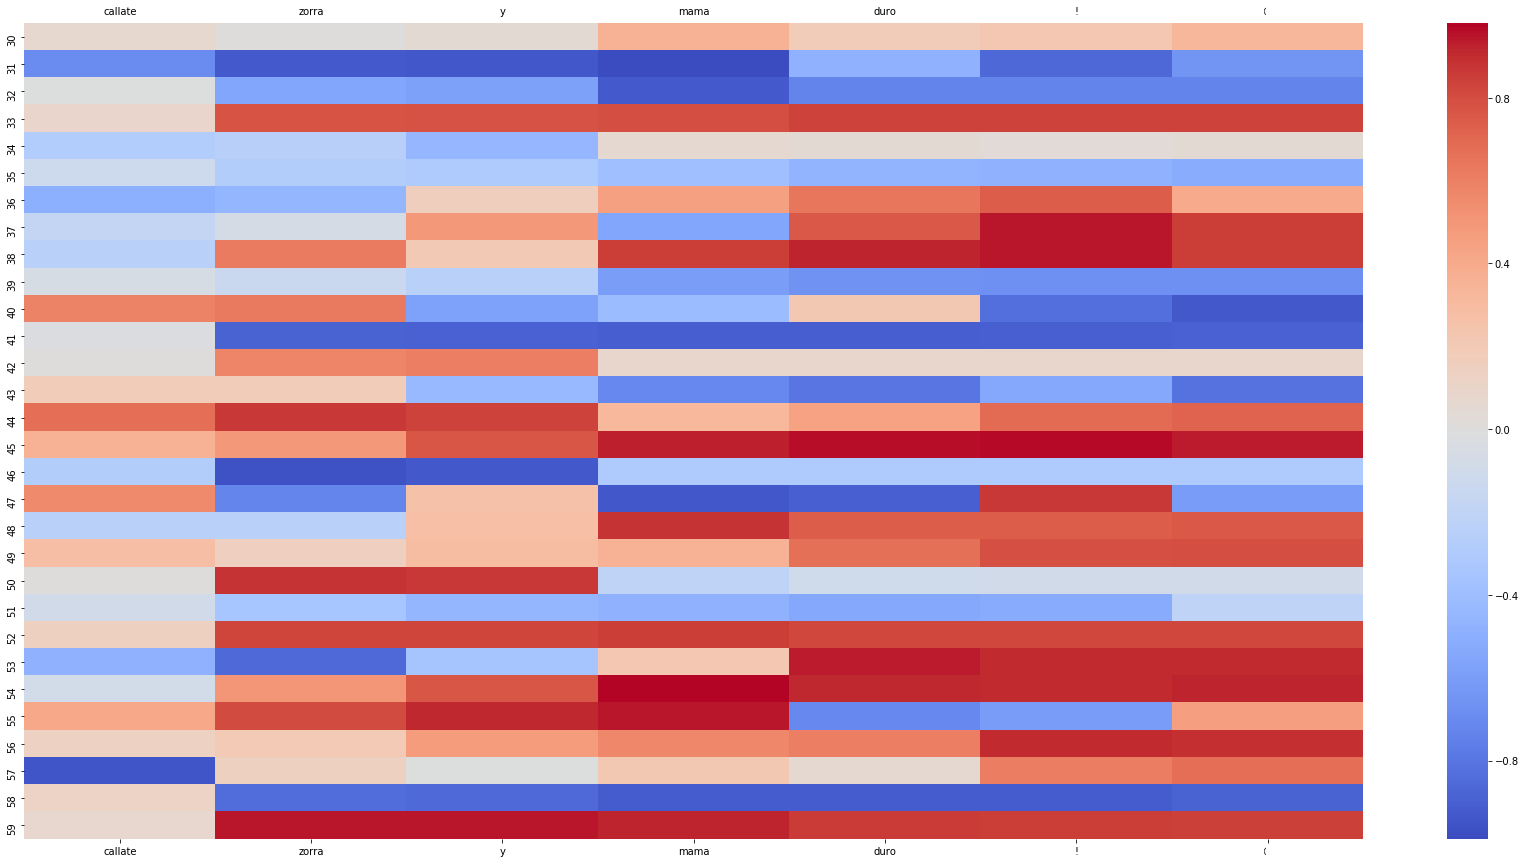

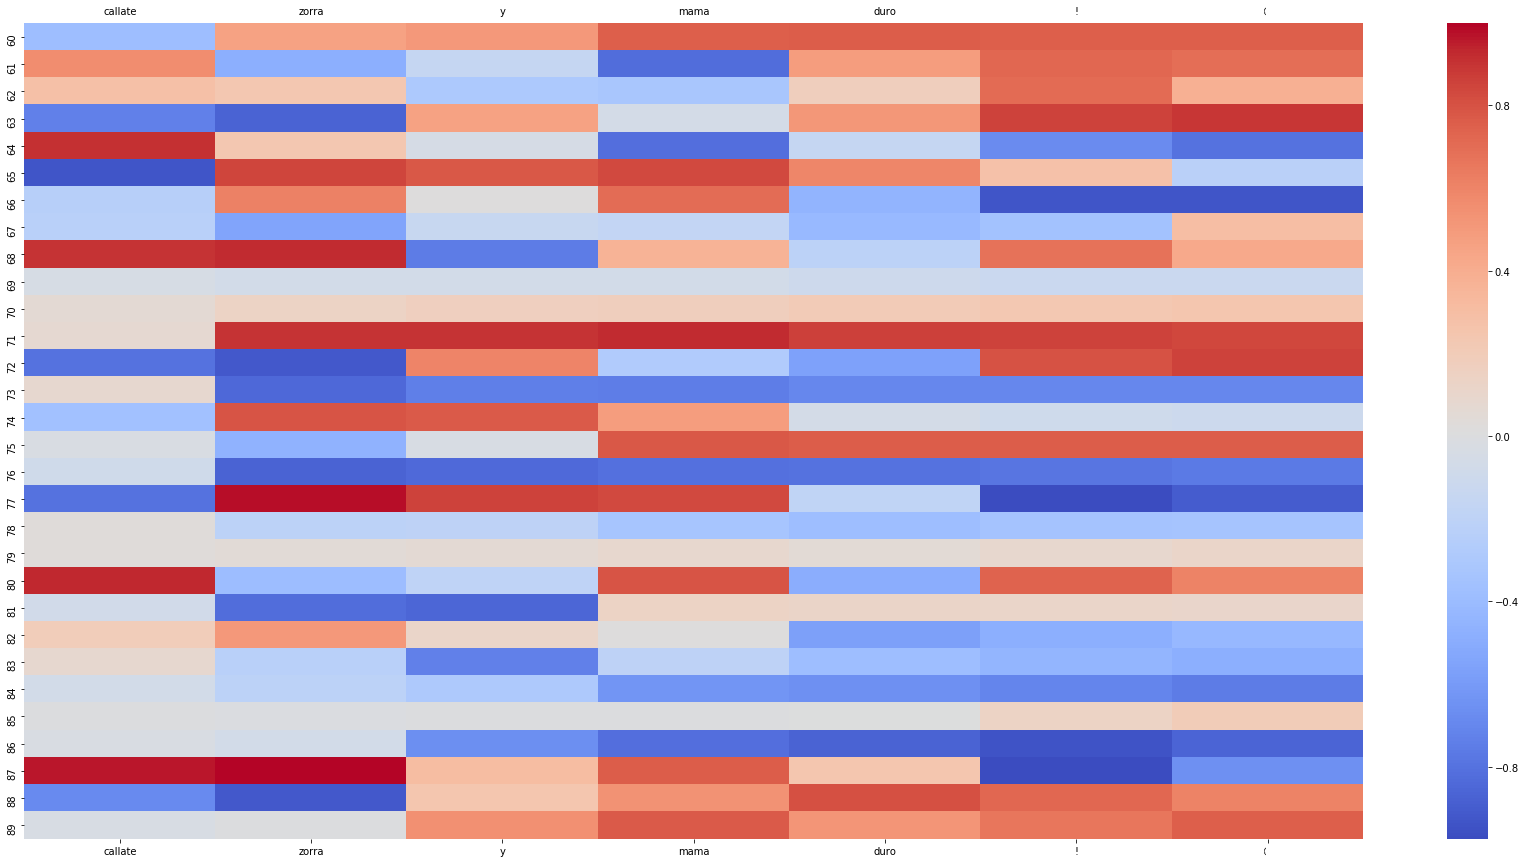

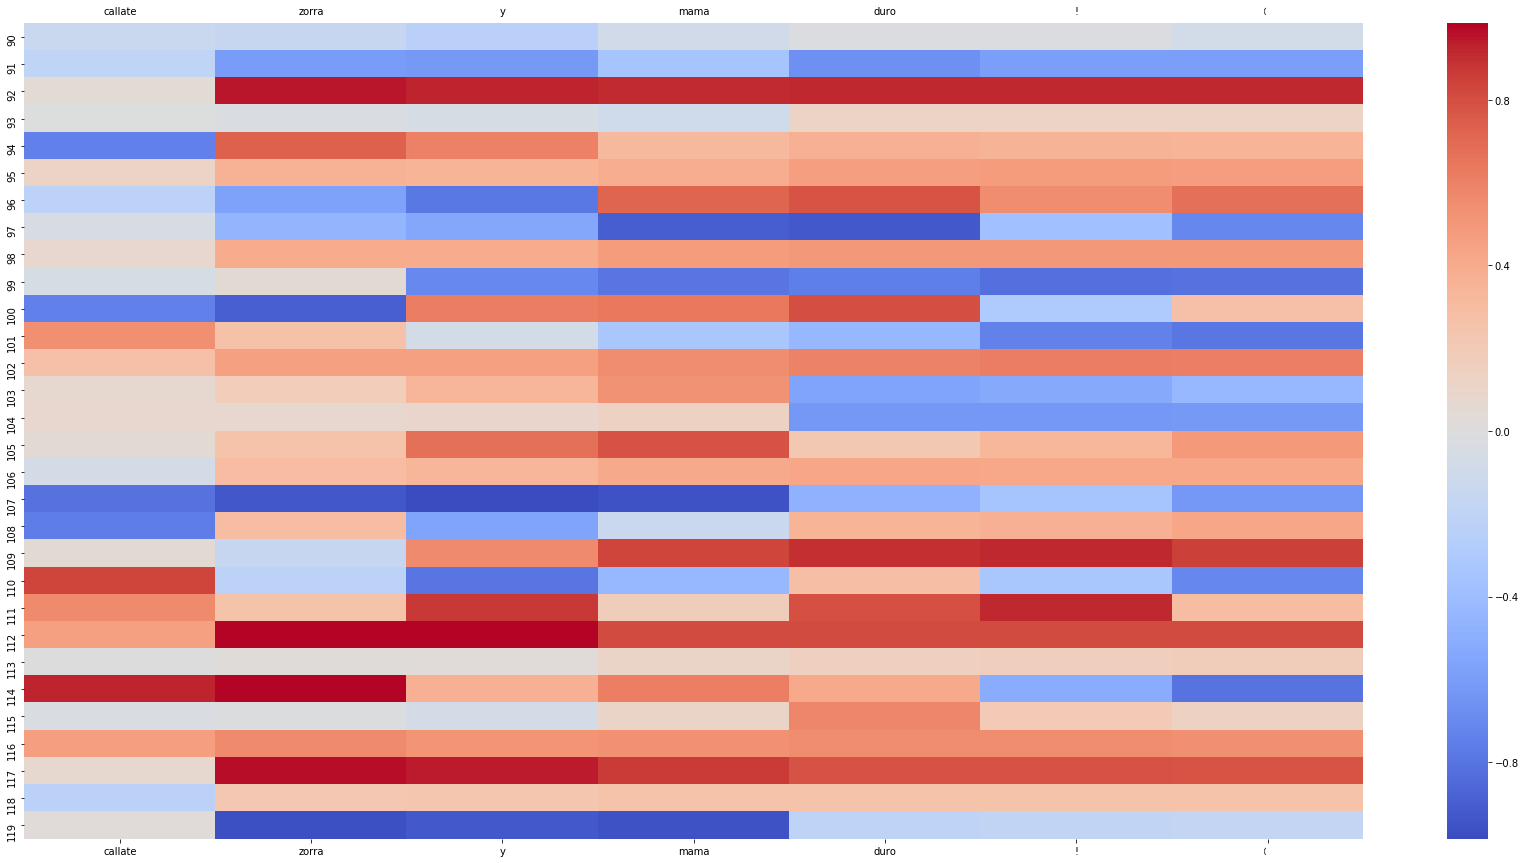

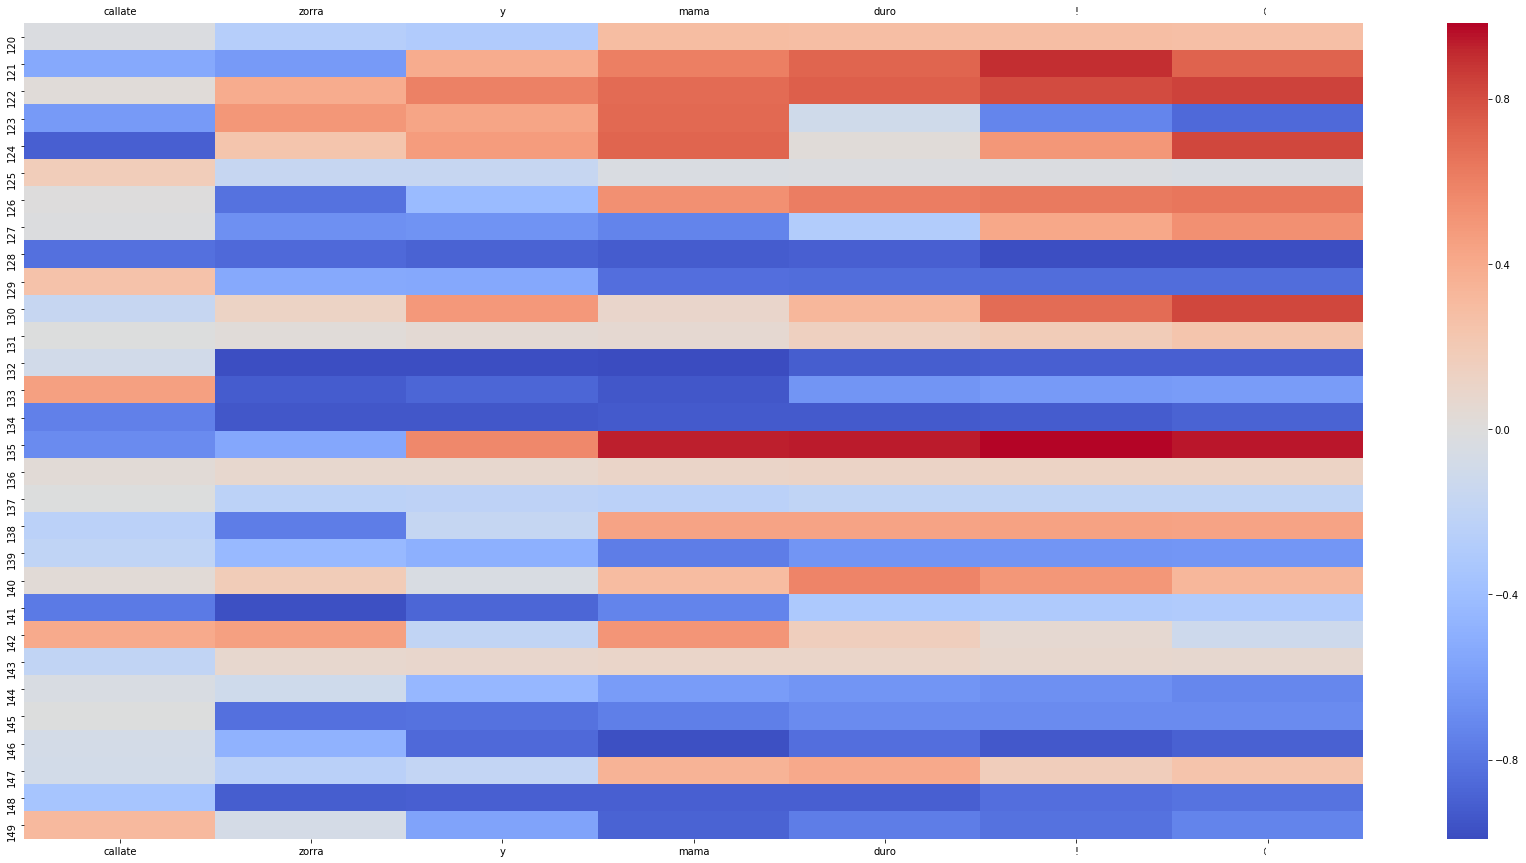

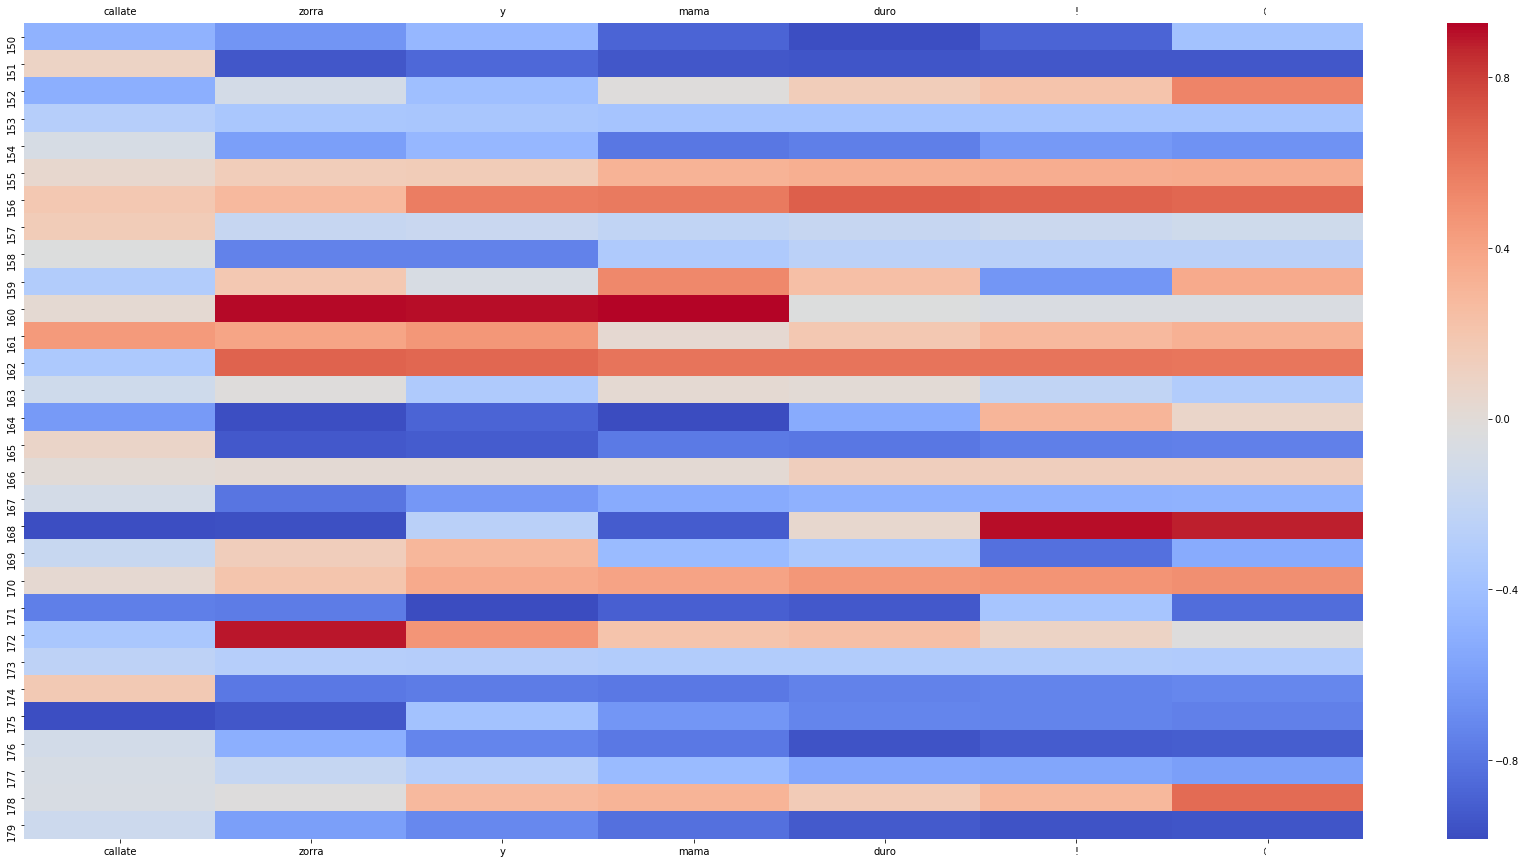

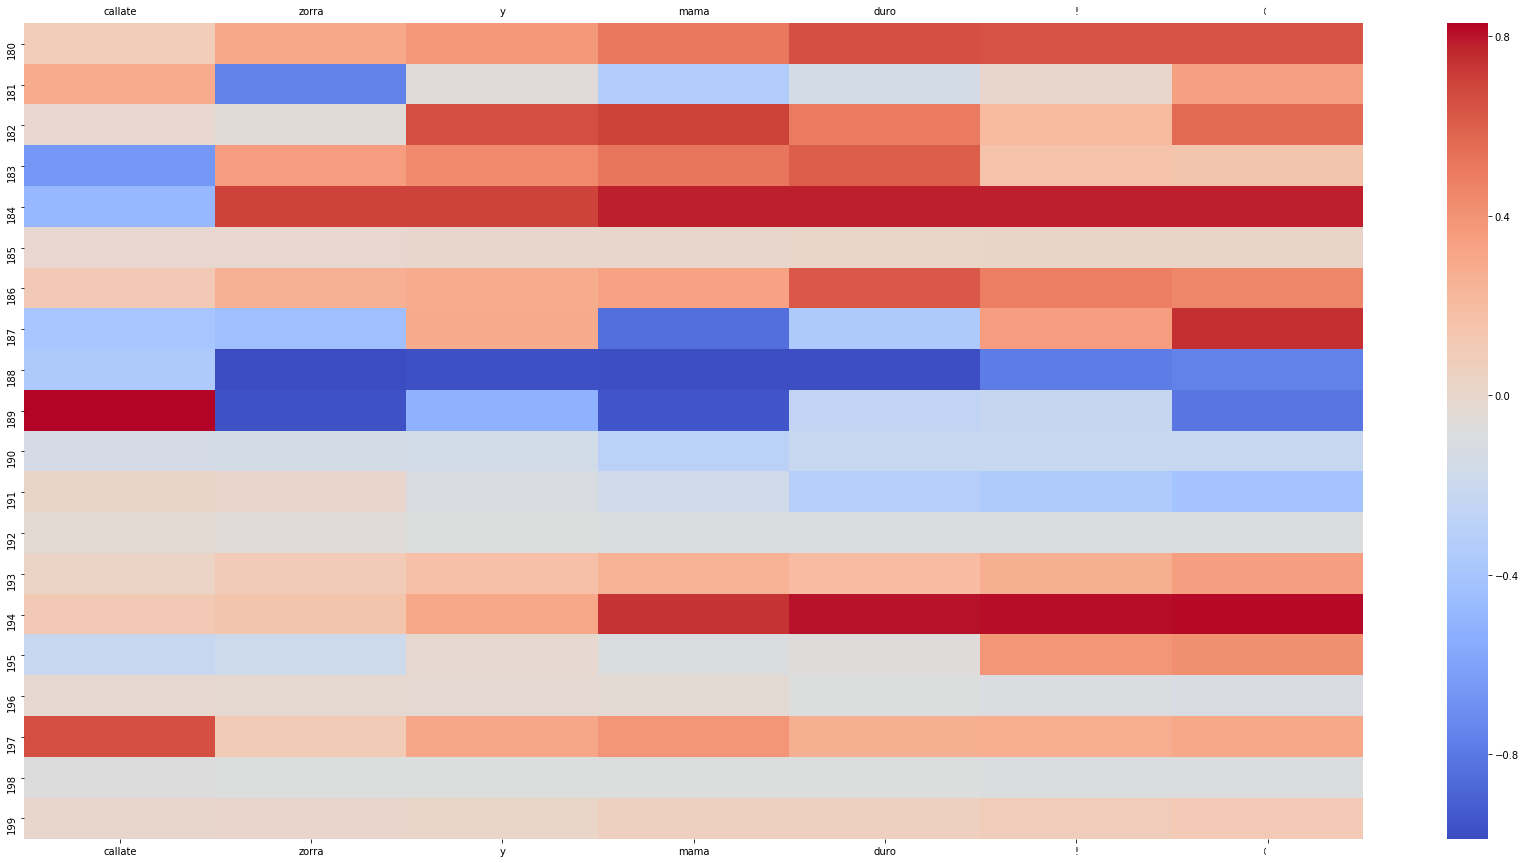

In [31]:
plot_recurrent_outputs(true_positives.iloc[0]["text"])

## Proporción de Agresivos

In [ ]:
print("Proporción de agresivos :", sum(df_dev["AG"] == 0) / len(df_dev))

hs = df_dev[df_dev["HS"] == 1]

print("Correlación AG - TR:", hs["AG"].corr(hs["TR"]))

## Falsos negativos

Vamos a etiquetar la profanidad. Considero profanidad todo aquellas palabras de uso vulgar (puta, perra, zorra, coño, negratas, musulmonos) pero no así aquellas que sean marcadoras de discurso racista pero no vulgar (negro, subsahariano)

In [24]:
pd.set_option('max_colwidth', 400)



print("Totales = ", len(false_negatives))
print("No AG ({}) AG ({})".format(sum(false_negatives["AG"] == 0), sum(false_negatives["AG"] == 1)))
false_negatives[["text", "proba", "HS", "AG", "PROFANITY"]]

Totales =  43
No AG (13) AG (30)


,text,proba,HS,AG,PROFANITY
id,,,,,
22065,| lo único que dominas es mi polla en tu cara. https://t.co/qlYOd4zPwW,0.121054,1.0,1.0,0
24590,"SOMOS MUCHO MÁS DE LO QUE SUEÑAS SER PINCHÉ SUDACA CAGADO, y si no te gusta dime donde nos topamos pa reventarnos el hocico 1:1 @amarchesin1 https://t.co/vHHPBKS1AK",0.132304,1.0,1.0,0
20019,"""Y NADIE SE HA PREGUNTADO LO QUE LE VA A COSTAR AL HOMBRE DEL GUANTAZO LA SITUACION..?!? PORQUE SEGURO ES, QUE EL MENDA MUSULMONO LE VA A PONER UNA DENUNCIA, QUE EL FALLO VA A SER """"CULPABLE"""", QUE UNA PANDILLA DE MUSULMONOS LE VA A ESTAR ESPERANDO DELANTE DE LA PUERTA DE SU NEGOCIO https://t.co/DjfA63A0T2""",0.160285,1.0,1.0,0
23688,"Ninguna mujer es tan santa como para no aprender a coger bien, ni tan puta como para no aprender a amar.",0.164225,1.0,1.0,0
24126,LA SOLUCIÓN ES SOLDARLE EL TIMÓN DE LA PATERA RUMBO DE DONDE SALIERON CON AGUA Y COMIDA. https://t.co/59pInBdgnR,0.192824,1.0,0.0,0
22560,@CarlaEUrena @FelipeCalderon Callateeeee !! Puta gallina cacarea !! Ni idea tienes de nada .,0.198251,1.0,1.0,0
20175,"Ay Dios cuando se entere Casado de que la ola de calor viene dada por la entrada masiva, sin papeles, de aire subsahariano",0.206844,1.0,0.0,0
24925,"La verdad que si, no veia la hora de llegar a los 5 mil amigos😂 ahora de a poco voy borrando esos indios indocumentados😂 https://t.co/Xw8q4GLM8v",0.208395,1.0,0.0,0
21072,"Voy andando por la calle y me han dicho cosas en árabe ya que me estas acosando dime lo en español para que te entienda, asique como yo no les entiendo me he cagado en su puta madre en árabe para que ellos a mi si.",0.224856,1.0,1.0,0


## Falsos Positivos

In [ ]:
pd.set_option('max_colwidth', 300)



print("Totales = ", len(false_positives))
print("No AG ({}) AG ({})".format(sum(false_positives["AG"] == 0), sum(false_positives["AG"] == 1)))
false_positives[["text", "proba", "HS", "AG"]]